---

<div style="text-align: center; font-size: 36px;"> <b> COSC6336: Homework-3 Report </b></div>
<div style="text-align: center; font-size: small;">submitted by</div>
<div style="text-align: center; font-size: large;">Mohammad Rajiur Rahman</div>
<div style="text-align: center; font-size: small;">UHID: XXXXXXX </div>


---

# Introduction

The aim of the work is to learn sequence to sequence (seq2seq) models. Introduced for the first time in 2014 by Google, a sequence to sequence model aims to map a fixed-length input with a fixed-length output where the length of the input and output may differ. From the high-level view, a seq2seq model has encoder, decoder and intermediate step as its main components. The class tutorial shows an excellent example of a minimalistic implementation of seq2seq model. The goal of the homework is to make this model efficient using batches and analyze the models' performance.

The overall architechture of the class tutorial was kept which is uses a single LSTM layer with one direction on both the encoder and decoder. Two models were designed. One with attention and another without attention. Both models works with batches of input. <b>The model with attention achieved 98.80% accuracy on test test.</b>

# Dataset

The task uses a toy dataset from automatically-generated data. It has 20000 records for training and 5000 for validation. The test dataset of 2000 records are fixed (provided in a text file: <a href='test.txt'>test.txt</a>). The test dataset is different in terms of length of input and output compared to training and validation dataset

|       	| Train Input 	| Train Output 	| Validation Input 	| Validation Ouptut 	| Test Input 	| Test output 	|
|:-----:	|------------:	|-------------:	|-----------------:	|------------------:	|-----------:	|------------:	|
| count 	|       20000 	|        20000 	|             5000 	|              5000 	|       5000 	|        5000 	|
| mean  	|       13.02 	|         5.77 	|            12.92 	|              5.72 	|      23.80 	|        6.82 	|
| std   	|        5.04 	|         1.94 	|             5.03 	|              1.96 	|      10.27 	|        2.51 	|
| min   	|           3 	|            1 	|                3 	|                 1 	|          3 	|           2 	|
| 25%   	|           9 	|            4 	|                9 	|                 4 	|         15 	|           5 	|
| 50%   	|          13 	|            6 	|               13 	|                 6 	|         23 	|           7 	|
| 75%   	|          17 	|            7 	|               17 	|                 7 	|         32 	|           9 	|
| max   	|          28 	|           10 	|               28 	|                10 	|         58 	|          13 	|

Importing required libraries

In [44]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os.path
from os import path
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

Setting up environment (cuda, if available otherwise cpu)

In [45]:
device = 'cpu'
#uncomment following line if cuda is available
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Populate Dataset**

In [46]:
# nothing changed from baseline code
torch.manual_seed(1)
random.seed(1)
def sorting_letters_dataset(size):
    dataset = []
    for _ in range(size):
        x = []
        for _ in range(random.randint(3, 10)):
            letter = chr(random.randint(97, 122))
            repeat = [letter] * random.randint(1, 3)
            x.extend(repeat)
        y = sorted(set(x))
        dataset.append((x, y))
    return zip(*dataset)

train_inp, train_out = sorting_letters_dataset(20_000)
valid_inp, valid_out = sorting_letters_dataset(5_000)

**Create Vocabulary**

In [47]:
# nothing changed from baseline code
class Vocab:
    def __init__(self, vocab):
        self.itos = vocab
        self.stoi = {d:i for i, d in enumerate(self.itos)}
        
    def __len__(self):
        return len(self.itos) 
    
src_vocab = Vocab(['<pad>'] + [chr(i+97) for i in range(26)])
tgt_vocab = Vocab(['<pad>'] + [chr(i+97) for i in range(26)] + ['<stop>','<start>'] )

In [48]:
START_IX = tgt_vocab.stoi['<start>']
STOP_IX  = tgt_vocab.stoi['<stop>']
PAD_IX = tgt_vocab.stoi['<pad>']

**Process Data**

Converting data to numeric values.

In [49]:
# minor chages from baseline code
def map_elems(elems, mapper, istarget=False):
    if istarget: # add stop if target
         return [mapper[elem] for elem in elems]+[STOP_IX]
    else: 
         return [mapper[elem] for elem in elems]

def map_many_elems(many_elems, mapper, istarget):
    return [map_elems(elems, mapper, istarget) for elems in many_elems]

train_x = map_many_elems(train_inp, src_vocab.stoi, istarget=False)
train_y = map_many_elems(train_out, tgt_vocab.stoi, istarget=True) # add stop token if target

valid_x = map_many_elems(valid_inp, src_vocab.stoi, istarget=False)
valid_y = map_many_elems(valid_out, tgt_vocab.stoi, istarget=True) # add stop token if target

**Batching Process** 

Functions to Create Batch of Data with Padding 


In [50]:
# Pad a sequence with the PAD symbol
def pad_seq(seq, max_length):
    result = [] + seq
    result += [PAD_IX for i in range(max_length - len(seq))]
    return result

# Pad batch of sequesnces
def pad_batch(seqs, max_length):
    return [pad_seq(x, max_length) for x in seqs]

# process batch: sort them by length of sequences, add stopad them 
def process_batch(input_seqs, target_seqs):
    
    # Zip into pairs, sort by length (descending), unzip
    seq_pairs = sorted(zip(input_seqs, target_seqs), key=lambda p: len(p[0]), reverse=True)
    input_seqs, target_seqs = zip(*seq_pairs)
    
    # For input and target sequences, get array of lengths and pad with 0s to max length
    input_lengths = [len(s) for s in input_seqs]
    input_padded = [pad_seq(s, max(input_lengths)) for s in input_seqs] # max_seq_len_input = max(input_lengths)
    target_lengths = [len(s) for s in target_seqs]
    target_padded = [pad_seq(s, max(target_lengths)) for s in target_seqs] # max_seq_len_target = max(input_lengths)
    
    # Turn padded arrays into tensors 
    input_var = (torch.LongTensor(input_padded)) # (batch_size x max_seq_len_input) 
    target_var = (torch.LongTensor(target_padded)).transpose(0, 1) #transpose target into (max_seq_len_target x batch_size)
    input_lengths = (torch.LongTensor(input_lengths)) # batch_size
    target_lengths = (torch.LongTensor(target_lengths)) # batch_size
    
    input_var = input_var.to(device) # move to device
    target_var = target_var.to(device) # move to device
    
    return input_var, input_lengths, target_var, target_lengths


# Architecture

The batched sequence to sequence model process a batch of sequences in parallel. The main technic lies in creating batches of data and then tranposing targets/output for training/evaluating as the target sequences are sent to decoder in batches. Decoder in models without batching takes one token at a single time stamp, where as decoder with batching takes batch_size times tokens at a single time stamp. 

### Batch Encoder

Embedded input sequences (batch_size x max_seq_len_input x emb_dim) are packed (1 x batch_size*max_seq_len_input*emb_dim) before sending to LSTM layer to get rid of pading. The output of LSTM layer is unpacked to get back to padded batches of outputs (batch_size x max_seq_len_input x lstm_size). Both packing and unpacking, along with LSTM, use <code>batch_first = True</code>

In [51]:
# Modified to process batch of inputs in parallel
class BatchEncoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, lstm_size, z_type, dropout=0.1):
        super(BatchEncoder, self).__init__()
        self.z_index = z_type
        
        self.emb = nn.Embedding(vocab_size, emb_dim,padding_idx=PAD_IX)
        self.lstm = nn.LSTM(emb_dim, lstm_size, batch_first=True)
        self.drop = nn.Dropout(dropout)
    
    def forward(self, input_seqs, input_lengths):
        
        # input_seqs shape: # batch_size x max_seq_len_input
        embedded = self.emb(input_seqs) # batch_size x max_seq_len_input x emb_dim
        embedded = self.drop(embedded) # batch_size x max_seq_len_input x emb_dim
        
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths.cpu().numpy(), batch_first=True)
        outputs, (h_n, c_n) = self.lstm(packed)

        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)  # unpack (back to padded)
        # outputs shape:  batch_size x max_seq_len_input x lstm_size
        
        if self.z_index == 1:
            return h_n[0], c_n[0] # (max_seq_len_input x lstm_dim)
        else:
            return outputs # batch_size x max_seq_len_input x lstm_size

batchencoder = BatchEncoder(vocab_size=len(src_vocab), emb_dim=64, lstm_size=128, z_type=1)
batchencoder

BatchEncoder(
  (emb): Embedding(27, 64, padding_idx=0)
  (lstm): LSTM(64, 128, batch_first=True)
  (drop): Dropout(p=0.1, inplace=False)
)

### Decoders

Two decoders were implemented: simple batched decoder and batched decoder with attentiom. Major contribution of this work over baseline example:
<ul>
    <li>Both the decoder implments batch processing of input for training and prediction. </li>
    <li>They also implements variable 'Teacher Forcing' (the baseline model has 100% teacher forcing).</li>
</ul>    

### Batch Decoder



In [52]:
# Modified to process batch of inputs in parallel
class BatchDecoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, lstm_size, dropout=0.5, teacher_forcing_ratio=1.0):
        super(BatchDecoder, self).__init__()
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.emb = nn.Embedding(vocab_size, emb_dim,padding_idx=PAD_IX) #ignore pad tokens 
        self.lstm = nn.LSTMCell(emb_dim, lstm_size)
        self.clf = nn.Linear(lstm_size, vocab_size)
        self.drop = nn.Dropout(dropout)
        self.objective = nn.CrossEntropyLoss(reduction="none", ignore_index = PAD_IX) #ingore pads for loss calclation
        
    def forward(self, state, targets, target_lengths, curr_tokens):
        device = next(self.parameters()).device
        
        # tragets shape: max_seq_len_target x batch_size 
        # target_lenghts shape: batch_size
        # curr_tokens shape: batch_size 
        
        loss = 0
        
        for i in range(targets.size(0)): # check i-th seq of all seqs in the batch
            inp = curr_tokens

            emb = self.emb(inp) #batch_size x emb_dim
            emb = self.drop(emb) #batch_size x emb_dim
            
            state = self.lstm(emb, state) #batch_size x lstm_size
            q_i, _ = state #batch_size x lstm_size
            q_i = self.drop(q_i) #batch_size x lstm_size
            scores = self.clf(q_i) # batch_size x tgt_vocab_len
            
            # loss ignores pads at tokens for loss calculation
            loss += self.objective(scores, targets[i]) #batch_size
            
            # checks if random probability is lower than teacher forcing ration
            # if teacher_forcing_ratio=1.0, 100% teacher forcing is applied
            if random.random() < self.teacher_forcing_ratio: 
                curr_tokens = targets[i]  # Ground truth as next token
            else:
                soft_scores = torch.softmax(scores, dim=1)
                curr_tokens = torch.argmax(scores, dim=1) # predicted output as next token

        return loss.sum()/target_lengths.sum() # sum (loss per batch) / (length of each seq in the batch)
    
    def predict(self, state, curr_tokens, maxlen):
        preds = [] # list to append predictions
        # curr_tokens shape: batch_size

        # loop through for predict batch_size tokens at each time step for batch_size seuquences 
        # maxlen is max_seq_len_target
        for i in range(maxlen):
            inp = curr_tokens #batch_size x emb_dim
            emb = self.emb(inp) #batch_size x emb_dim
            state = self.lstm(emb, state) #batch_size x lstm_size
            h_i, _ = state #batch_size x lstm_size
            scores = self.clf(h_i) # batch_size x tgt_vocab_len
            scores = torch.softmax(scores, dim=1) # batch_size x tgt_vocab_len
            pred = torch.argmax(scores, dim=1) # batch_size
            curr_tokens = pred # batch_size
            preds.append(pred)
            
        # transpose the predicted output to batch_size x max_seq_len_target
        # use len(target sequence) or <stop> token to remove extra predicted words
        finalpreds =  []
        for j in range(len(preds[0])): # loop throgh batch
            temp = []
            for i in range(len(preds)): # for 0 to len(sequences)
                l = preds[i].cpu().data.numpy() 
                if(l[j] != STOP_IX): # if not a <stop> token
                    temp.append(l[j]) # append to sequence
            finalpreds.append(temp) # append to sequence to batch     
        return finalpreds, preds 

### Batch Decoder with Attention

In [53]:
# no changes from the baseline code
class BatchAttention(nn.Module):
    def __init__(self, input_dim, attn_dim):
        super(BatchAttention, self).__init__()
        self.W = nn.Linear(input_dim, attn_dim)
        self.v = nn.Linear(attn_dim, 1, bias=False)
        
    def forward(self, dec_hidden, enc_outs):
        seqlen = enc_outs.size(1)
        
        repeat_h = dec_hidden.unsqueeze(1)  # make room to repeat on seqlen dim
        repeat_h = repeat_h.repeat(1, seqlen, 1)  # (1, seqlen, hidden)

        concat_h = torch.cat((enc_outs, repeat_h), dim=2) # (1, seqlen, hidden*2)
        
        scores = self.v(torch.tanh(self.W(concat_h))) # (1, seqlen, 1)
        probs = torch.softmax(scores, dim=1)
        
        weighted = enc_outs * probs # (1, seqlen, hidden)
        
        context = torch.sum(weighted, dim=1, keepdim=False) # (1, hidden)
        combined = torch.cat((dec_hidden, context), dim=1)  # (1, hidden*2)
        
        return combined

In [54]:
# Modified to process batch of inputs in parallel
class BatchAttentionDecoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, lstm_size, attn_size, dropout=0.5, teacher_forcing_ratio=1.0):
        super(BatchAttentionDecoder, self).__init__()
        
        self.lstm_size = lstm_size
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=PAD_IX)
        self.lstm = nn.LSTMCell(emb_dim, lstm_size)
        self.attn = BatchAttention(lstm_size * 2, attn_size)
        self.clf = nn.Linear(lstm_size * 2, vocab_size)
        
        self.drop = nn.Dropout(dropout)
        self.objective = nn.CrossEntropyLoss(reduction="none", ignore_index = PAD_IX)
    
    
    def init_state(self, device, batch_size):
        # no change in code for init_state
        h_0 = torch.zeros(batch_size, self.lstm_size).to(device)  # (batch, hidden_size)
        c_0 = torch.zeros(batch_size, self.lstm_size).to(device)  # (batch, hidden_size)
        return h_0, c_0
        
    def forward(self, enc_outs, targets, target_lengths, curr_tokens):
        loss = 0
        
        # tragets shape: max_seq_len_target x batch_size 
        # target_lenghts shape: batch_size
        # curr_tokens shape: batch_size 
        
        batch_size = targets.size(1)
        max_seq_len = targets.size(0)
        
        # intilialize the state to 0
        state = self.init_state(device, batch_size)
        
        for i in range(max_seq_len):# check i-th seq of all seqs in the batch
            
            inp = curr_tokens
            emb = self.emb(inp) # batch_size x emb_dim
            emb = self.drop(emb) #batch_size x emb_dim
            
            state = self.lstm(emb, state) # batch_size x lstm_size
            q_i, _ = state  # batch_size x lstm_size
            q_i = self.drop(q_i) # batch_size x lstm_size
            
            combined = self.attn(q_i, enc_outs) # batch_size x lstm_size*2
            
            scores = self.clf(combined) # batch_size x tgt_vocab_size
            loss += self.objective(scores, targets[i]) # batch_size
            
            # checks if random probability is lower than teacher forcing ration
            # if teacher_forcing_ratio=1.0, 100% teacher forcing is applied
            if random.random() < self.teacher_forcing_ratio: # Teacher Forcing Ration = 0.5
                curr_tokens = targets[i]  # Ground truth as next token
            else:
                soft_scores = torch.softmax(scores, dim=1)
                curr_tokens = torch.argmax(scores, dim=1) # predicted output as next token
            
        return loss.sum() / target_lengths.sum() # sum (loss per batch) / (length of each seq in the batch)

    def predict(self, enc_outs, curr_tokens, maxlen):
        preds = [] # list to append predictions
        # curr_tokens shape: batch_size

        device = enc_outs.device
        state = self.init_state(device, len(curr_tokens))
        
        # loop through for predict batch_size tokens at each time step for batch_size seuquences 
        # maxlen is max_seq_len_target
        
        for i in range(maxlen):
            inp = curr_tokens #batch_size x emb_dim
            emb = self.emb(inp) #batch_size x emb_dim
            state = self.lstm(emb, state) #batch_size x lstm_size
            q_i, _ = state
            combined = self.attn(q_i, enc_outs)  # batch_size x lstm_size*2
            scores = self.clf(combined) # batch_size x tgt_vocab_len
            scores = torch.softmax(scores, dim=1 ) # batch_size x tgt_vocab_len
            pred = torch.argmax(scores, dim=1) # batch_size
            curr_tokens = pred # batch_size
                
            preds.append(pred)
        
        # transpose the predicted output to batch_size x max_seq_len_target
        # use len(target sequence) or <stop> token to remove extra predicted words
        
        finalpreds =  []
        for j in range(len(preds[0])): # loop throgh batch
            temp = []
            for i in range(len(preds)): # for 0 to len(sequences)
                l = preds[i].cpu().data.numpy() 
                if(l[j] != STOP_IX): # if not a <stop> token
                    temp.append(l[j]) # append to sequence
            finalpreds.append(temp) # append to sequence to batch     
        return finalpreds, preds 

# Traning

### Utility Functions

In [55]:
# function to track best model at training epochs, modified from RNN tutorial
def track_best_model(model_path, encoder, decoder, epoch, best_acc, dev_acc):
    if best_acc > dev_acc:
        return best_acc, ''
    state = {
        'epoch': epoch,
        'acc': dev_acc,
        'encoder': encoder.state_dict(),
        'decoder': decoder.state_dict()
    }
    torch.save(state, model_path)
    return dev_acc, ' # BEST # '

# same as base model
def shuffle(x, y):
    pack = list(zip(x, y))
    random.shuffle(pack)
    return zip(*pack)

def currenttime():
    return datetime.datetime.now().strftime("%Y%m%d_%H%M")

In [56]:
# functions to convert int sequence to char sequence in batches
# LIMITATION: order of original input-target pair is not sorted, how for packing & unpacking at batched encoder they were sorted
# Hence, output of prediction from decoder is sorted as well, needs to update the fucnctions or adjust accordingly 

# funciton to convert int sequences to char sequence (string)
def itow(tokenlist, vocab, sep=''):
    return ''.join(vocab.itos[i] for i in tokenlist)

# convert batch predictions of int sequences to char sequence
# same batch has sequences with different length
def convert(predcitionlist, target_lengths, vocab):
    #print(vocab)
    target_lengths = target_lengths.data.cpu().numpy()
    result = []
    for i in range(len(predcitionlist)):
        pred = predcitionlist[i][:target_lengths[i]]
        
        word =""
        for token in pred:
            if(token==STOP_IX or token==PAD_IX):
                break
            else:
                word += vocab.itos[token]  

        result.append(word)
        
    return result

# function to get accurary of a batch of input
# LIMITATION: works for batch_size=1 only, discussed before
def accuracy(encoder, decoder, input_x,input_y):
    encoder.eval()
    decoder.eval()
      
    start_batch_inputs = torch.LongTensor([START_IX] * len(input_x)).to(device) #start with <start> token x batch_size
    input_input_var, input_input_lengths, input_target_var, input_target_lengths = process_batch(input_x,input_y)
    
    seq_pairs = sorted(zip(input_x,input_y), key=lambda p: len(p[0]), reverse=True)
    input_x,input_y = zip(*seq_pairs)
    
    maxlen = max(input_target_lengths.data.cpu().numpy())    
    encoder_state = encoder(input_input_var, input_input_lengths)
    predictions, rawpred = decoder.predict(encoder_state, start_batch_inputs, maxlen=maxlen)

    # LIMITATION: order of input_y_converted and predic_converted are not same
    input_x_converted = convert(input_x, input_input_lengths,tgt_vocab)
    input_y_converted = convert(input_y, input_target_lengths,tgt_vocab) 
    predic_converted = convert(predictions, input_target_lengths,tgt_vocab)

    count = 0
    for i in range(len(input_x)):
        if input_y_converted[i]==predic_converted[i]:
            count+=1      
    return (count/len(input_x))

# function to overcome accuracy fucntion's limitation to get accurary for batches
def batchaccuracy(encoderloaded, decoderloaded, test_x, test_y):
    total = 0
    for i in range(len(test_x)):
        total += accuracy(encoderloaded, decoderloaded, [test_x[i]], [test_y[i]])
    return total/len(test_x) 

In [57]:
def evaluation(encoder, decoder, input_x, input_y, batch_size):
    encoder.eval()
    decoder.eval()
    
    total_loss = 0 
    for i in range(len(input_x)//batch_size):
        x = input_x[i*batch_size:(i+1)*batch_size]
        y = input_y[i*batch_size:(i+1)*batch_size]
            
        input_var, input_lengths, target_var, target_lengths = process_batch(x,y)
        start_inputs = torch.LongTensor([START_IX] * batch_size).to(device)
            
        total_loss += decoder(encoder(input_var, input_lengths),target_var, target_lengths, start_inputs)
    return total_loss.item()

### Train Function

In [58]:
def train(savefilename, encoder, decoder, train_x, train_y, train_size, valid_x, valid_y,valid_size, batch_size=50, valid_batch_size=50, 
          epochs=10, print_every=1, plot_every=1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    assert(len(train_x) == len(train_y))
    assert(len(valid_x) == len(valid_y))
    
    train_losses = []
    valid_losses = []
    
    encoder.to(device)
    decoder.to(device)

    enc_optim = optim.SGD(encoder.parameters(), lr=0.001, momentum=0.99)
    dec_optim = optim.SGD(decoder.parameters(), lr=0.001, momentum=0.99)

    best_acc=0
    
    for epoch in range(1, epochs+1):
        encoder.train()
        decoder.train()

        
        encoder.zero_grad(); enc_optim.zero_grad()
        decoder.zero_grad(); dec_optim.zero_grad()

        train_x, train_y = shuffle(train_x, train_y)
        train_x, train_y = train_x[:train_size], train_y[:train_size]
        
        epoch_train_loss = 0
        epoch_valid_loss = 0
        
        val_acc = 0
        epoch_track =''
        
        for i in range(len(train_x)//batch_size):
            x = train_x[i*batch_size:(i+1)*batch_size]
            y = train_y[i*batch_size:(i+1)*batch_size]
            
            input_var, input_lengths, target_var, target_lengths = process_batch(x,y)
            
            start_inputs = torch.LongTensor([START_IX] * batch_size).to(device)
            
            batch_loss = decoder(encoder(input_var, input_lengths),target_var, target_lengths, start_inputs)
            
            batch_loss.backward()
            enc_optim.step()
            dec_optim.step()

            encoder.zero_grad(); enc_optim.zero_grad()
            decoder.zero_grad(); dec_optim.zero_grad()

            epoch_train_loss += batch_loss.item()
            #batch_loss = 0
            
            
            del x, y, input_var, input_lengths, target_var, target_lengths 
    

        #VALIDATION
        
        encoder.train(False)
        decoder.train(False)
        
        
        valid_x, valid_y = shuffle(valid_x, valid_y)
        valid_x, valid_y =valid_x[:valid_size], valid_y[:valid_size] 
        
        epoch_train_loss = epoch_train_loss / (len(train_x)//batch_size)
        epoch_valid_loss = evaluation(encoder, decoder, valid_x, valid_y, valid_batch_size) / (len(valid_x)//valid_batch_size)
  
        train_losses.append(epoch_train_loss)
        valid_losses.append(epoch_valid_loss)
        
        if epoch % print_every == 0:
            accuracy_total_valid = 0
            for v in range(len(valid_x)//valid_batch_size):
                vx = valid_x[v*valid_batch_size:(v+1)*valid_batch_size]
                vy = valid_y[v*valid_batch_size:(v+1)*valid_batch_size]
                val_input_batches, val_input_lengths, val_target_batches, val_target_lengths= process_batch(valid_x, valid_y)
                accuracy_total_valid += batchaccuracy(encoder, decoder, vx,vy)
            val_acc = accuracy_total_valid / (len(valid_x)//valid_batch_size)

            #tracks and saves the best model
            best_acc, epoch_track = track_best_model(savefilename+'-BEST.pt', encoder, decoder , epoch, best_acc, val_acc)
            
            print(f"**** Epoch {epoch} - Train Loss: {epoch_train_loss:.6f} - Valid Loss: {epoch_valid_loss:.6f} - Validaiton Accuracy: {val_acc:.4f} **** "+\
                  currenttime()+ " "+epoch_track )     

    return encoder, decoder, train_losses, valid_losses

### Model Parameters

In [59]:
train_size = 20000
valid_size = 5000
batch_size = 10
epochs = 10
attention = True
print_every = 1
teacher_forcing_ratio=1.0
attn_size = 100

### Model-1 Definitions  (No Attention)

In [60]:
#encoder decoder without attention
encoder1 = BatchEncoder(vocab_size=len(src_vocab), emb_dim=64, lstm_size=128, z_type=1)
decoder1 = BatchDecoder(vocab_size=len(tgt_vocab), emb_dim=64, lstm_size=128)

#encoder decoder with attention
#encoder = BatchEncoder(vocab_size=len(src_vocab), emb_dim=64, lstm_size=128, z_type=0)
#decoder = BatchAttentionDecoder(vocab_size=len(tgt_vocab), emb_dim=64, lstm_size=128, attn_size=attn_size, teacher_forcing_ratio = teacher_forcing_ratio)

print(encoder1)
print(decoder1)    

BatchEncoder(
  (emb): Embedding(27, 64, padding_idx=0)
  (lstm): LSTM(64, 128, batch_first=True)
  (drop): Dropout(p=0.1, inplace=False)
)
BatchDecoder(
  (emb): Embedding(29, 64, padding_idx=0)
  (lstm): LSTMCell(64, 128)
  (clf): Linear(in_features=128, out_features=29, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (objective): CrossEntropyLoss()
)


### Load or Train the Model-1 (No Attention)

In [61]:
savedmodelpath = 'model-1.pt'
# check if model exists, then load
if path.exists(savedmodelpath):
    state_dict = torch.load(savedmodelpath)
    encoder1.load_state_dict(state_dict['encoder'])
    decoder1.load_state_dict(state_dict['decoder'])
# if model doesn't exiting train the model
else:
    savefilename = 'model_no-attn-batched-'+currenttime()
    encoder1, decoder1, train_losses1,valid_losses1 = train(savefilename, encoder1, decoder1, train_x, train_y, train_size, valid_x, 
                         valid_y,valid_size, batch_size=batch_size, valid_batch_size=batch_size, epochs=epochs, print_every=1, plot_every=1)
    torch.save({'encoder': encoder1.state_dict(),'decoder': decoder1.state_dict()}, savefilename+'-final.pt')

**** Epoch 1 - Train Loss: 2.410730 - Valid Loss: 1.930187 - Validaiton Accuracy: 0.0000 **** 20200410_0744  # BEST # 
**** Epoch 2 - Train Loss: 1.658312 - Valid Loss: 1.080642 - Validaiton Accuracy: 0.0690 **** 20200410_0754  # BEST # 
**** Epoch 3 - Train Loss: 1.055140 - Valid Loss: 0.501405 - Validaiton Accuracy: 0.3400 **** 20200410_0804  # BEST # 
**** Epoch 4 - Train Loss: 0.635189 - Valid Loss: 0.215385 - Validaiton Accuracy: 0.6684 **** 20200410_0813  # BEST # 
**** Epoch 5 - Train Loss: 0.365940 - Valid Loss: 0.086178 - Validaiton Accuracy: 0.8646 **** 20200410_0823  # BEST # 
**** Epoch 6 - Train Loss: 0.220170 - Valid Loss: 0.036451 - Validaiton Accuracy: 0.9448 **** 20200410_0833  # BEST # 
**** Epoch 7 - Train Loss: 0.145917 - Valid Loss: 0.024169 - Validaiton Accuracy: 0.9608 **** 20200410_0843  # BEST # 
**** Epoch 8 - Train Loss: 0.102736 - Valid Loss: 0.012598 - Validaiton Accuracy: 0.9812 **** 20200410_0853  # BEST # 
**** Epoch 9 - Train Loss: 0.080204 - Valid Loss

### Model Definitions

In [62]:
#encoder decoder without attention
#encoder = BatchEncoder(vocab_size=len(src_vocab), emb_dim=64, lstm_size=128, z_type=1)
#decoder = BatchDecoder(vocab_size=len(tgt_vocab), emb_dim=64, lstm_size=128)
#encoder decoder with attention
encoder2 = BatchEncoder(vocab_size=len(src_vocab), emb_dim=64, lstm_size=128, z_type=0)
decoder2 = BatchAttentionDecoder(vocab_size=len(tgt_vocab), emb_dim=64, lstm_size=128, attn_size=attn_size, teacher_forcing_ratio = teacher_forcing_ratio)

print(encoder2)
print(decoder2)    

BatchEncoder(
  (emb): Embedding(27, 64, padding_idx=0)
  (lstm): LSTM(64, 128, batch_first=True)
  (drop): Dropout(p=0.1, inplace=False)
)
BatchAttentionDecoder(
  (emb): Embedding(29, 64, padding_idx=0)
  (lstm): LSTMCell(64, 128)
  (attn): BatchAttention(
    (W): Linear(in_features=256, out_features=100, bias=True)
    (v): Linear(in_features=100, out_features=1, bias=False)
  )
  (clf): Linear(in_features=256, out_features=29, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (objective): CrossEntropyLoss()
)


### Load or Train the Model

In [63]:
savedmodelpath = 'model.pt'
# check if model exists, then load
if path.exists(savedmodelpath):
    state_dict = torch.load(savedmodelpath)
    encoder2.load_state_dict(state_dict['encoder'])
    decoder2.load_state_dict(state_dict['decoder'])
# if model doesn't exiting train the model
else:
    savefilename = 'model_attn-batched-'+currenttime()
    encoder2, decoder2, train_losses2,valid_losses2 = train(savefilename, encoder2, decoder2, train_x, train_y, train_size, valid_x, 
                         valid_y,valid_size, batch_size=batch_size, valid_batch_size=batch_size, epochs=epochs, print_every=1, plot_every=1)
    torch.save({'encoder': encoder2.state_dict(),'decoder': decoder2.state_dict()}, savefilename+'-final.pt')

**** Epoch 1 - Train Loss: 2.233419 - Valid Loss: 1.311370 - Validaiton Accuracy: 0.0166 **** 20200410_0923  # BEST # 
**** Epoch 2 - Train Loss: 0.935489 - Valid Loss: 0.308623 - Validaiton Accuracy: 0.5738 **** 20200410_0934  # BEST # 
**** Epoch 3 - Train Loss: 0.340313 - Valid Loss: 0.073064 - Validaiton Accuracy: 0.8882 **** 20200410_0945  # BEST # 
**** Epoch 4 - Train Loss: 0.171135 - Valid Loss: 0.040715 - Validaiton Accuracy: 0.9274 **** 20200410_0956  # BEST # 
**** Epoch 5 - Train Loss: 0.116868 - Valid Loss: 0.024313 - Validaiton Accuracy: 0.9550 **** 20200410_1007  # BEST # 
**** Epoch 6 - Train Loss: 0.089508 - Valid Loss: 0.016572 - Validaiton Accuracy: 0.9684 **** 20200410_1017  # BEST # 
**** Epoch 7 - Train Loss: 0.066823 - Valid Loss: 0.011105 - Validaiton Accuracy: 0.9736 **** 20200410_1028  # BEST # 
**** Epoch 8 - Train Loss: 0.058287 - Valid Loss: 0.011745 - Validaiton Accuracy: 0.9654 **** 20200410_1039 
**** Epoch 9 - Train Loss: 0.051461 - Valid Loss: 0.009020

### Plotting Training and Validation Loss

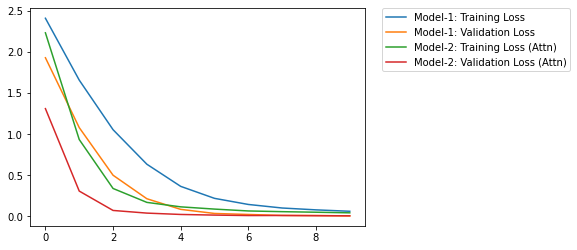

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(epochs)

plt.plot(x, train_losses1, label="Model-1: Training Loss")
plt.plot(x, valid_losses1, label="Model-1: Validation Loss")
plt.plot(x, train_losses2, label="Model-2: Training Loss (Attn)")
plt.plot(x, valid_losses2, label="Model-2: Validation Loss (Attn)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Evaluation

In [65]:
test_data = pd.read_csv('test.txt', delimiter='\t', header=None, usecols=[0,1])
test_inp, test_out = test_data[0], test_data[1]
test_x = map_many_elems(test_inp, src_vocab.stoi, istarget=False)
test_y = map_many_elems(test_out, tgt_vocab.stoi, istarget=True)

In [66]:
print("Model-1 (No Attention) Test Accuracy:", batchaccuracy(encoder1, decoder1, test_x, test_y))

Model-1 (No Attention) Test Accuracy: 0.9362


In [67]:
print("Model-2 (Attention) Test Accuracy:", batchaccuracy(encoder2, decoder2, test_x, test_y))

Model-2 (Attention) Test Accuracy: 0.977


# Analysis

In this section, different performance metrics are analyzed for following two designed models. 
<br/> <b>Model-1: Batched Sequence-to-Sequence</b>
<br/> <b>Model-2: Batched Sequence-to-Sequence with Attention</b>

Models were tested with different batch size, epochs and teacher forcing ratio on GPU (Colab) and CPU (PC).

<b>GPU vs CPU Performance.</b> As expected, system with GPU (Colab) performed almost three times faster to achieve similar validation accurary while keeping other parameters same.

|   System  | Model-Type | Epoch-5 | Teacher-Forcing | BatchSize | Avg Time (Minutes) | Validation Accuracy |
|:---------:|------------|--------:|----------------:|----------:|-------------------:|--------------------:|
| GPU-Colab | Attn       |       5 |               1 |        10 |                  7 |              97.12% |
| CPU       | Attn       |       5 |               1 |        10 |                 20 |              97.64% |

<b>Batch Size.</b> On the same system (example Colab GPU), for constant teacher forcing ratio increase Batch Size takes lesser time for each epoch but, validation accuracy was lower after same number of epochs. The training data sets were not sorted. As a result batches required random padding. Training data could be sorted ('bucketing' technique) to minimize the padded and then batches could be randomly selected for training. More padding required the batches to run longer for the largest sequence in the batch.

|   System  | Model-Type | Epoch-5 | Teacher Forcing | Batch Size | Avg Time (Minutes) | Validation Accuracy |
|:---------:|------------|:-------:|:---------------:|:----------:|:------------------:|:-------------------:|
| GPU-Colab | Attn       |    5    |        1        |      5     |         16         |        99.10%       |
| GPU-Colab | Attn       |    5    |        1        |     10     |          7         |        97.12%       |
| GPU-Colab | Attn       |    5    |        1        |     25     |          4         |        67.30%       |

<b>Teacher Forcing.</b> Models had slower convergence when teacher forcing ratio was set to 50%. Lower teacher forcing ratio is expected to slowdown the convergence and cause instability. Without teacher forcing, sequence prediction models use the output from the last time step y(t-1) as input for the model at the current time step X(t).  Teacher forcing works by using the actual or expected output from the training dataset at the current time step y(t) as input in the next time step X(t+1), rather than the output generated by the network.

| System | Model-Type | Epoch-5 | Teacher-Forcing | BatchSize | Avg Time (Minutes) | Validation Accuracy |
|:------:|------------|--------:|----------------:|----------:|-------------------:|--------------------:|
| CPU    | Attn       |       5 |               1 |        10 |                 20 |              97.64% |
| CPU    | Attn       |       5 |             0.5 |        10 |                N/R |              91.34% |

<b>Attention.</b> Model with Attention works faster and achieves better validation accurary (result shows one sample experiment for comparison, best model was trained with 50 epochs for best accuracy). 

| System | Model-Type | Epoch-5 | Teacher-Forcing | BatchSize | Avg Time (Minutes) | Validation Accuracy |
|:------:|------------|--------:|----------------:|----------:|-------------------:|--------------------:|
| CPU    | Attn       |      10 |               1 |        10 |                 10 |              97.70% |
| CPU    | No Attn    |      10 |               1 |        10 |                  9 |              93.62% |




# References

I referred to class tutorial [1] and following online examples to implement the models:
1. https://github.com/gaguilar/basic_nlp_tutorial/
2. https://medium.com/@adam.wearne/seq2seq-with-pytorch-46dc00ff5164
3. https://github.com/RRisto/seq2seq
4. https://github.com/howardyclo/pytorch-seq2seq-example
5. https://towardsdatascience.com/understanding-encoder-decoder-sequence-to-sequence-model-679e04af4346
6. https://towardsdatascience.com/tuned-version-of-seq2seq-tutorial-ddb64db46e2a
7. https://github.com/pengyuchen/PyTorch-Batch-Seq2seq
8. https://github.com/spro/practical-pytorch/
9. https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/
